# Residual Block Module, Micro/Mini ResNet, for Image Classification of Bird and Dog Species

### In this experiment, two custom ResNet models are going to be tested for classifying bird and dog species images.

In the first model, I will be implementing a simple ResNet50 module and create a Convolutional Neural Network for image classification of the bird and dog species dataset.

## Implementation

Implementation of a Simple ResNet50-based Micro-ResNet CNN architecture using Keras for classification of the bird and dog species dataset.

## Lineup of tasks

1. Implementation of a Simple ResNet50-based Mini-ResNet CNN architecture for classifying the bird and dog species dataset using the Keras API.

2. Train and test the model

3. Based on the performance, aim is to add layers, apply transfer learning and check for improvements. 
`
**Dataset Structure:**
- train: ../train/images
- val: ../valid/images
- test: ../test/images
- nc: 20
- names: ['BARN SWALLOW', 'BARRED PUFFBIRD', 'BLACK BAZA', 'BURCHELLS COURSER', 'COPPERY TAILED COUCAL', 'EASTERN BLUEBIRD', 'EMPEROR PENGUIN', 'Gordon_setter', 'JACK SNIPE', 'Leonberg', 'MOURNING DOVE', 'SHOEBILL', 'Shetland_sheepdog', 'Sussex_spaniel', 'Tibetan_terrier', 'flat-coated_retriever', 'giant_schnauzer', 'golden_retriever', 'malinois', 'toy_terrier']

**Reference and adapted from:** https://github.com/alinarw/ResNet/blob/master/ResNet.ipynb

## The ResNet base model begins!

### Step 1: Import required packages

We will need tensorflow, numpy, os and keras


In [ ]:
## For visualisation
!pip install pydot
!pip install --upgrade pydot graphviz
!pip install pydot_ng==2.0.0



In [12]:
import keras
from keras.layers import Layer
import keras.backend as K
import tensorflow as tf

from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten, BatchNormalization, Activation, Add

from keras.layers import MaxPooling2D, Input
from keras.initializers import glorot_uniform

import cv2
import numpy as np

from keras import backend as K
from keras import utils

from keras import backend as K
from keras.regularizers import l2

import math
from keras.optimizers import SGD, Adam, Adadelta
from keras.callbacks import LearningRateScheduler
from keras.activations import relu, softmax
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from sklearn.metrics import confusion_matrix

from keras.utils import plot_model
#from keras.utils.vis_utils import model_to_dot
from IPython.display import HTML, display, clear_output, SVG

import warnings
warnings.filterwarnings("ignore")


### Step 1: Extracting the dataset. 

### We will do the following:

1. Extracts images from a zip file (imported into the AWS workspace) into a folder, we will call it 'image_dataset'.
2. Assigns labels to the images based on their folder names and splits the data into train, validation, and test sets.
3. Returns the train, validation, and test data along with their labels and a label mapping dictionary.

In [13]:
import zipfile
import os
import shutil


label_map = {}
extracted_folder = "image_dataset"

def extract_and_process_images(zip_file_path):
    # Extract the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_folder)

    # Remove _MACOSX folder if it exists
    macosx_folder = os.path.join(extracted_folder, "__MACOSX")
    if os.path.exists(macosx_folder) and os.path.isdir(macosx_folder):
        shutil.rmtree(macosx_folder)


In [ ]:
import zipfile
import os
import shutil


label_map = {}
extracted_folder = "image_dataset"

def extract_and_process_images(zip_file_path):
    # Extract the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_folder)

    # Remove _MACOSX folder if it exists
    macosx_folder = os.path.join(extracted_folder, "__MACOSX")
    if os.path.exists(macosx_folder) and os.path.isdir(macosx_folder):
        shutil.rmtree(macosx_folder)


In [14]:
zip_file_path = "data/dataset.zip"
extract_and_process_images(zip_file_path)

In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

extracted_folder = "image_dataset"
image_index = 0

def assign_labels_to_images(test_size=0.2, val_size=0.2, random_state=24580348):
    global image_index

    # As each label is assigned a numeric, we will need a dictionary to map between words (folder names) and numeric labels
    label_map = {}
    labels = []
    images = []

    # Iterate through each folder in the extracted folder
    for i, folder_name in enumerate(sorted(os.listdir(extracted_folder))):
        label_map[folder_name] = i
        folder_path = os.path.join(extracted_folder, folder_name)
        if os.path.isdir(folder_path):
            label = label_map[folder_name]
            # Iterate through each image file in the folder
            for image_file in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_file)
                if os.path.isfile(image_path):
                    # Read image using OpenCV
                    img = cv2.imread(image_path)
                    # Append image and label to lists
                    images.append(img)
                    labels.append(label)
                    image_index += 1

    # Split data into train, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=random_state)



    return X_train, X_val, X_test, y_train, y_val, y_test, label_map

# Example usage
X_train, X_val, X_test, y_train, y_val, y_test, label_map = assign_labels_to_images(test_size=0.1, val_size=0.2, random_state=24580348)

In [3]:
print("Number of samples in training set (X_train, y_train):", len(X_train), len(y_train))
print("Number of samples in validation set (X_val, y_val):", len(X_val), len(y_val))
print("Number of samples in test set (X_test, y_test):", len(X_test), len(y_test))


Number of samples in training set (X_train, y_train): 2215 2215
Number of samples in validation set (X_val, y_val): 636 636
Number of samples in test set (X_test, y_test): 314 314



#### We will now check the distribution of data across labels.

In [4]:
from collections import Counter

def print_label_distribution(labels, label_map):
    label_counts = Counter(labels)
    for label, count in label_counts.items():
        label_name = list(label_map.keys())[list(label_map.values()).index(label)]
        print(f"{label_name}: {count}")

# Get the label distributions
print("Train label distribution:")
print_label_distribution(y_train, label_map)

print("\nValidation label distribution:")
print_label_distribution(y_val, label_map)

print("\nTest label distribution:")
print_label_distribution(y_test, label_map)

Train label distribution:
BARN SWALLOW: 98
giant_schnauzer: 106
BLACK BAZA: 111
SHOEBILL: 110
Gordon_setter: 102
malinois: 110
toy_terrier: 112
Shetland_sheepdog: 108
BARRED PUFFBIRD: 98
EMPEROR PENGUIN: 105
COPPERY TAILED COUCAL: 110
JACK SNIPE: 110
Sussex_spaniel: 109
Leonberg: 147
Tibetan_terrier: 148
flat-coated_retriever: 102
BURCHELLS COURSER: 112
EASTERN BLUEBIRD: 102
MOURNING DOVE: 106
golden_retriever: 109

Validation label distribution:
Shetland_sheepdog: 27
SHOEBILL: 33
toy_terrier: 39
BLACK BAZA: 31
Tibetan_terrier: 39
Sussex_spaniel: 27
COPPERY TAILED COUCAL: 28
giant_schnauzer: 38
JACK SNIPE: 30
Gordon_setter: 32
BARRED PUFFBIRD: 27
BARN SWALLOW: 22
flat-coated_retriever: 30
golden_retriever: 27
BURCHELLS COURSER: 29
EASTERN BLUEBIRD: 38
malinois: 32
Leonberg: 46
MOURNING DOVE: 30
EMPEROR PENGUIN: 31

Test label distribution:
toy_terrier: 21
Sussex_spaniel: 15
flat-coated_retriever: 20
EMPEROR PENGUIN: 17
SHOEBILL: 21
Shetland_sheepdog: 22
Gordon_setter: 19
Leonberg: 17
M


#### Based on the output, it is clear that the label distributions are not evenly distributed across the different classes. The number of images varies significantly for different labels in the train, validation, and test sets.

#### For instance, in the train set, the number of images ranges from 83 for 'BARRED PUFFBIRD' to 128 for 'Tibetan_terrier'. Similarly, in the validation set, the number of images ranges from 21 for 'BARN SWALLOW' to 44 for 'Leonberg'. 

#### This imbalance in the dataset could potentially affect the performance of the model, especially for the classes with fewer examples. To help address this issue, we will pass the class weights we have calculated below to the fit() method when training our model.

In [5]:
# Calculate class weights to be used in the fit method later. 
class_weights = {}
for label in label_map.values():
    class_weights[label] = 1 / y_train.count(label)

In [6]:
print (class_weights)

{0: 0.01020408163265306, 1: 0.01020408163265306, 2: 0.009009009009009009, 3: 0.008928571428571428, 4: 0.00909090909090909, 5: 0.00980392156862745, 6: 0.009523809523809525, 7: 0.00980392156862745, 8: 0.00909090909090909, 9: 0.006802721088435374, 10: 0.009433962264150943, 11: 0.00909090909090909, 12: 0.009259259259259259, 13: 0.009174311926605505, 14: 0.006756756756756757, 15: 0.00980392156862745, 16: 0.009433962264150943, 17: 0.009174311926605505, 18: 0.00909090909090909, 19: 0.008928571428571428}


In [7]:
import numpy as np

# Printing the unique classes
train_unique_values = np.unique(y_train)
test_unique_values = np.unique(y_test)

print("Unique values in y_train:", train_unique_values)
print("Unique values in y_test:", test_unique_values)

Unique values in y_train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Unique values in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]



### Data Preprocessing- Image resizing and data normalisation. 

In [8]:
#X_train, X_test, y_train, y_test
from keras.utils import to_categorical

img_rows = 256
img_cols = 256

# Resize training images
X_train = np.array([cv2.resize(img, (img_rows, img_cols)) for img in X_train])
X_val = np.array([cv2.resize(img, (img_rows, img_cols)) for img in X_val])
X_test = np.array([cv2.resize(img, (img_rows, img_cols)) for img in X_test])

# # Transform targets to keras compatible format
y_train = to_categorical(y_train, 20)
y_val = to_categorical(y_val, 20)
y_test = to_categorical(y_test, 20)  

# Convert the data type to float32
X_train_resized = X_train.astype('float32')
X_val_resized = X_val.astype('float32')
X_test_resized = X_test.astype('float32')

# Preprocess data by scaling pixel values to the range [0, 1]
X_train_resized /= 255.0
X_val_resized /= 255.0
X_test_resized /= 255.0


2024-05-13 12:01:53.868917: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F AVX512_VNNI
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 12:01:54.028408: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2024-05-13 12:01:54.028547: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2024-05-13 12:01:54.028748: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-1

In [9]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Fit the data generator to your resized training set
train_datagen.fit(X_train_resized)

# Specify batch size for training
batch_size = 65

# Create augmented data generator for training
train_generator = train_datagen.flow(X_train_resized, y_train, batch_size=batch_size)


val_generator=(X_val_resized, y_val)


### Step 2- Baseline Model Preparation: Design a Micro-ResNet with 1 Layer of Residual Block




In [10]:
%matplotlib inline

In [10]:
def res_block(x, filters, dropout_rate=0.2, kernel_regularizer=None):
    print('Input Shape x.shape', x.shape)

    # Create 1X1 CONV, --> BatchNormalization --> Activation, Initialize weights with Xavier uniform initialization (glorot_uniform)
    conv1 = Conv2D(filters=filters, kernel_size=(1, 1), strides=(2, 2), padding='same',
                   kernel_initializer=glorot_uniform(seed=0),
                   kernel_regularizer=l2(1e-5))(x)
    bn1 = BatchNormalization()(conv1)
    act1 = Activation('relu')(bn1)
    act1 = Dropout(0.2)(act1)
    print('conv1.shape', conv1.shape)

    # Create 3X3 CONV, --> BatchNormalization --> Activation, Initialize weights with Xavier uniform initialization (glorot_uniform)
    conv2 = Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), padding='same',
                   kernel_initializer=glorot_uniform(seed=0),
                   kernel_regularizer=kernel_regularizer)(act1)
    bn2 = BatchNormalization()(conv2)
    act2 = Activation('relu')(bn2)
    act2 = Dropout(dropout_rate)(act2)  # Apply dropout after the activation
    print('conv2.shape', conv2.shape)

    # Create 1X1 CONV, --> BatchNormalization, Initialize weights with Xavier uniform initialization (glorot_uniform)
    conv3 = Conv2D(filters=filters, kernel_size=(1, 1), strides=(1, 1), padding='same',
                   kernel_initializer=glorot_uniform(seed=0),
                   kernel_regularizer=kernel_regularizer)(act2)
    bn3 = BatchNormalization()(conv3)
    print('conv3.shape', conv3.shape)

    # Create 1X1 CONV on the Input to re-shape
    x = Conv2D(filters=filters, kernel_size=(1, 1), strides=(2, 2), padding='same',
               kernel_regularizer=kernel_regularizer)(x)

    out = Add()([bn3, x])

    return out

In [13]:
# Define Images dimension and number of classes
img_rows, img_cols = 256, 256
input_shape = (img_rows, img_cols, 3)
num_classes = 20

# Create the input layer
input_layer = Input(shape=input_shape) # Use the actual input size

# Create 7X7X64 CONV --> BatchNormalization --> Activation
x = Conv2D(64, padding='same',
           kernel_initializer='he_normal',
           kernel_size=7, strides=2,
           )(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Add MaxPOOL, 3X3, Pad: Same, Stride: 2
x = MaxPooling2D(pool_size=3,padding='same', strides=2)(x)

# Add 1 ResNet block, 64 filter
res_block1 = res_block(x, 64)
print('---------block 1 end-----------')


# Add global average pooling for dimensionality reduction
res_block1 = keras.layers.GlobalAveragePooling2D()(res_block1)

# Create Classifier Block
# Add Flatten layer
classifer_Block = Flatten()(res_block1)

# Add Dense Layer, 1000 nodes, Activation - ReLU
classifer_Block = Dense(1000,
                activation='relu')(classifer_Block)
classifer_Block = Dropout(0.5)(classifer_Block)  # Dropout rate of 0.5 (50%)

# Add Dense Layer, 10 nodes, Activation = SoftMax
outputs = Dense(num_classes,
                activation='softmax')(classifer_Block)

2024-05-13 12:02:26.092739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-13 12:02:26.102257: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-13 12:02:26.105599: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-13 12:02:26.109048: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F AVX512_VNNI
To enable them in other operations, rebu

Input Shape x.shape (None, 64, 64, 64)
conv1.shape (None, 32, 32, 64)
conv2.shape (None, 32, 32, 64)
conv3.shape (None, 32, 32, 64)
---------block 1 end-----------


In [8]:
# kernel_init = keras.initializers.glorot_uniform()
# bias_init = keras.initializers.Constant(value=0.2)

In [14]:
# Form the model
model = Model(input_layer, outputs, name='Micro_ResNet')

In [15]:

model.summary()

#plot_model(model, to_file='model.png', show_layer_names=True, show_shapes=True, rankdir='TB')


Model: "Micro_ResNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                      

In [6]:
#model.save('base_imageclassifier_resnet_model.h5')


In [14]:
# from tensorflow.keras.models import load_model

# # Load the saved model weights
# model = load_model('base_imageclassifier_resnet_model.h5')



### Define the Hyper-parameters, Compile the model, Start training

In [16]:
# Recompile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [17]:
print("Number of samples in X_train_resized:", len(X_val_resized))
print("Number of samples in y_train:", len(y_val))


Number of samples in X_train_resized: 636
Number of samples in y_train: 636


In [18]:
from keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=[early_stopping]
)


Epoch 1/100


2024-05-13 12:03:00.376070: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inMicro_ResNet/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-13 12:03:02.055377: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2024-05-13 12:03:03.678105: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x5577d8cdfa50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-13 12:03:03.678155: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-05-13 12:03:03.685589: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-13 12:03:03.850601: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled clu

35/35 [==============================] - 31s 700ms/step - loss: 0.0255 - accuracy: 0.1499 - val_loss: 3.3018 - val_accuracy: 0.0503
Epoch 2/100
35/35 [==============================] - 27s 766ms/step - loss: 0.0219 - accuracy: 0.2497 - val_loss: 4.0584 - val_accuracy: 0.0676
Epoch 3/100
35/35 [==============================] - 27s 769ms/step - loss: 0.0200 - accuracy: 0.3187 - val_loss: 4.7104 - val_accuracy: 0.0456
Epoch 4/100
35/35 [==============================] - 27s 767ms/step - loss: 0.0185 - accuracy: 0.3472 - val_loss: 6.4781 - val_accuracy: 0.0440
Epoch 5/100
35/35 [==============================] - 27s 771ms/step - loss: 0.0181 - accuracy: 0.3806 - val_loss: 8.7026 - val_accuracy: 0.0346
Epoch 6/100
35/35 [==============================] - 27s 770ms/step - loss: 0.0173 - accuracy: 0.3928 - val_loss: 3.9486 - val_accuracy: 0.1085
Epoch 7/100
35/35 [==============================] - 27s 768ms/step - loss: 0.0172 - accuracy: 0.3955 - val_loss: 7.6246 - val_accuracy: 0.0865
Epoc

### Display Training and Validation accuracy curve

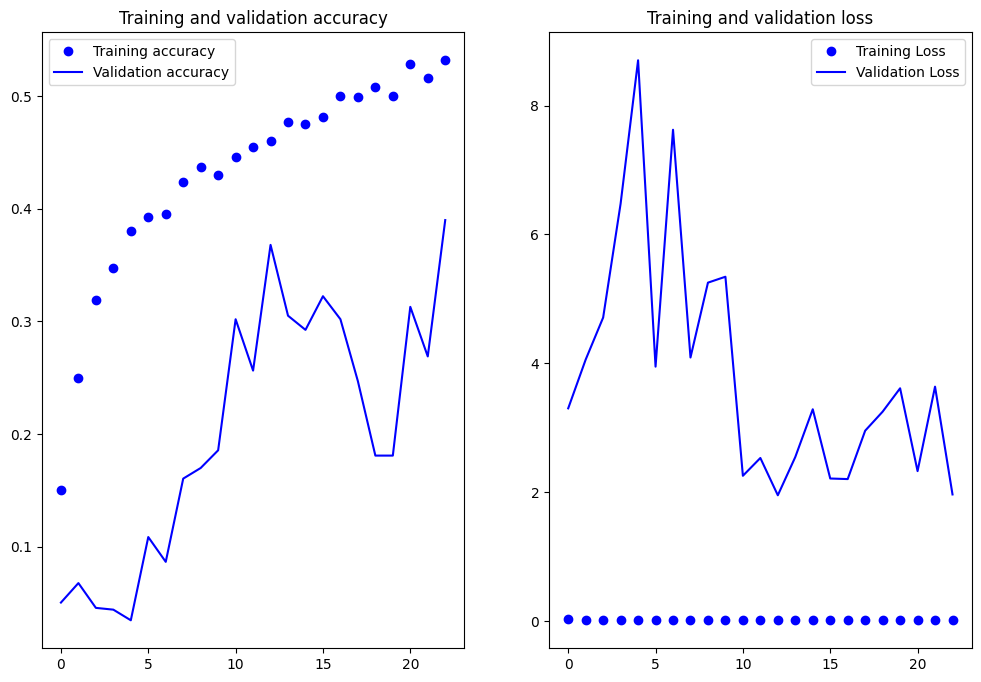

In [19]:
## Plot the Training and Validation loss
import matplotlib.pyplot as plt

acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Evaluating the results on Test set. 

In [22]:
scores = model.evaluate(X_test_resized, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


scores = model.evaluate(X_val_resized, y_val, verbose=1)
print('Val loss:', scores[0])
print('Val accuracy:', scores[1])


scores = model.evaluate(X_train_resized, y_train, verbose=1)
print('Train loss:', scores[0])
print('Train accuracy:', scores[1])

10/10 [==============================] - 0s 19ms/step - loss: 1.8152 - accuracy: 0.4076
Test loss: 1.8151865005493164
Test accuracy: 0.40764331817626953
20/20 [==============================] - 0s 16ms/step - loss: 1.9527 - accuracy: 0.3679
Val loss: 1.9527000188827515
Val accuracy: 0.3679245412349701
70/70 [==============================] - 1s 17ms/step - loss: 1.7063 - accuracy: 0.4465
Train loss: 1.706318736076355
Train accuracy: 0.44650113582611084


### Making changes to the baseline model with the below approach:

1. **Adding a pretrained model (Imagenet weights initialised) **: The model uses the ResNet50 architecture pretrained on ImageNet for feature extraction, excluding the top layers to facilitate transfer learning on a custom dataset.
  
2. **Custom ResBlocks**: Additional residual blocks are added to the base model to enhance feature learning with batch normalization and dropout for improved model performance.

3. **Classification Layers**: Just like the baseline model, Global average pooling is applied for dimensionality reduction followed by dense layers for classification, including dropout regularization to reduce overfitting, followed by a softmax activation layer for multi-class classification.


In [56]:
from tensorflow.keras.regularizers import l2

def res_block(x, filters, dropout_rate=0.2, kernel_regularizer=None):
    print('Input Shape x.shape', x.shape)

    # Create 1X1 CONV, --> BatchNormalization --> Activation, Initialize weights with Xavier uniform initialization (glorot_uniform)
    conv1 = Conv2D(filters=filters, kernel_size=(1, 1), strides=(2, 2), padding='same',
                   kernel_initializer=glorot_uniform(seed=0),
                   kernel_regularizer=l2(1e-4))(x)  # Increased regularization strength
    bn1 = BatchNormalization()(conv1)
    act1 = Activation('relu')(bn1)
    act1 = Dropout(0.1)(act1)  # Decreased dropout rate
    print('conv1.shape', conv1.shape)

    # Create 3X3 CONV, --> BatchNormalization --> Activation, Initialize weights with Xavier uniform initialization (glorot_uniform)
    conv2 = Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), padding='same',
                   kernel_initializer=glorot_uniform(seed=0),
                   kernel_regularizer=kernel_regularizer)(act1)
    bn2 = BatchNormalization()(conv2)
    act2 = Activation('relu')(bn2)
    act2 = Dropout(dropout_rate)(act2)  # Apply dropout after the activation
    print('conv2.shape', conv2.shape)

    # Create 1X1 CONV, --> BatchNormalization, Initialize weights with Xavier uniform initialization (glorot_uniform)
    conv3 = Conv2D(filters=filters, kernel_size=(1, 1), strides=(1, 1), padding='same',
                   kernel_initializer=glorot_uniform(seed=0),
                   kernel_regularizer=kernel_regularizer)(act2)
    bn3 = BatchNormalization()(conv3)
    print('conv3.shape', conv3.shape)

    # Create 1X1 CONV on the Input to re-shape
    x = Conv2D(filters=filters, kernel_size=(1, 1), strides=(2, 2), padding='same',
               kernel_regularizer=kernel_regularizer)(x)

    out = Add()([bn3, x])

    return out


In [57]:
from tensorflow.keras.applications import ResNet50


# We will load the pre-trained ResNet50 model without top layers
img_rows, img_cols = 256, 256  # Initialising the input shape again just in case the notebook stops running. 
input_shape = (img_rows, img_cols, 3)
num_classes = 20
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in base_model.layers:
    layer.trainable = True
x = base_model.output
# Adding custom ResBlock after base model
res_block1 = res_block(x, 64)
print('---------block 1 end-----------')
res_block2 = res_block(res_block1, 256)  # Added one more res block
print('---------block 2 end-----------')

# Adding global average pooling for dimensionality reduction
x = keras.layers.GlobalAveragePooling2D()(x)

# Adding custom classification layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Creating the final model
custom_resnet = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with Adam optimizer and categorical crossentropy loss
custom_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])





Input Shape x.shape (None, 8, 8, 2048)
conv1.shape (None, 4, 4, 64)
conv2.shape (None, 4, 4, 64)
conv3.shape (None, 4, 4, 64)
---------block 1 end-----------
Input Shape x.shape (None, 4, 4, 64)
conv1.shape (None, 2, 2, 256)
conv2.shape (None, 2, 2, 256)
conv3.shape (None, 2, 2, 256)
---------block 2 end-----------


In [55]:
# Print Model Summary
custom_resnet.summary()

#plot_model(model, to_file='model2.png', show_layer_names=True, show_shapes=True, rankdir='TB')
#SVG(model_to_dot(model, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg'))

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
from keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Define learning rate schedule
def lr_schedule(epoch):
    lr = 1e-4  # Initial learning rate decreased to 1e-4
    if epoch > 50:
        lr *= 0.1  # Will decrease learning rate after 50 epochs
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

# Train the model with early stopping and learning rate schedule
custom_resnet.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/200
35/35 [==============================] - 33s 929ms/step - loss: 0.0016 - accuracy: 0.9553 - val_loss: 3.2435 - val_accuracy: 0.0645 - lr: 1.0000e-04
Epoch 2/200
35/35 [==============================] - 32s 906ms/step - loss: 0.0015 - accuracy: 0.9517 - val_loss: 3.2943 - val_accuracy: 0.0472 - lr: 1.0000e-04
Epoch 3/200
35/35 [==============================] - 32s 900ms/step - loss: 7.6242e-04 - accuracy: 0.9765 - val_loss: 3.4340 - val_accuracy: 0.0472 - lr: 1.0000e-04
Epoch 4/200
35/35 [==============================] - 32s 891ms/step - loss: 4.4345e-04 - accuracy: 0.9878 - val_loss: 3.5498 - val_accuracy: 0.0472 - lr: 1.0000e-04
Epoch 5/200
35/35 [==============================] - 32s 902ms/step - loss: 5.7534e-04 - accuracy: 0.9801 - val_loss: 4.2138 - val_accuracy: 0.0676 - lr: 1.0000e-04
Epoch 6/200
35/35 [==============================] - 32s 892ms/step - loss: 0.0013 - accuracy: 0.9553 - val_loss: 3.4516 - val_accuracy: 0.0330 - lr: 1.0000e-04
Epoch 7/200
35/35 [===

In [ ]:
# from tensorflow.keras.callbacks import LearningRateScheduler
# from tensorflow.keras.optimizers import SGD

# def cosine_annealing(epoch, lr_max=0.01, lr_min=1e-6, epochs=200):
#     lr = lr_min + 0.5 * (lr_max - lr_min) * (1 + np.cos(epoch / epochs * np.pi))
#     return lr

# lr_scheduler = LearningRateScheduler(cosine_annealing)

# optimizer = SGD(lr=0.01)
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# model.fit(train_generator,
#           epochs=200,
#           validation_data=val_generator,
#           callbacks=[lr_scheduler])

In [62]:
# Form the Model
# Save model weights after training
custom_resnet.save_weights('custom_resnet_model_weights.h5')

In [67]:
scores = custom_resnet.evaluate(X_test_resized, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


scores = custom_resnet.evaluate(X_val_resized, y_val, verbose=1)
print('Val loss:', scores[0])
print('Val accuracy:', scores[1])


scores = custom_resnet.evaluate(X_train_resized, y_train, verbose=1)
print('Train loss:', scores[0])
print('Train accuracy:', scores[1])

10/10 [==============================] - 1s 108ms/step - loss: 0.2268 - accuracy: 0.9682
Test loss: 0.22683264315128326
Test accuracy: 0.9681528806686401
20/20 [==============================] - 2s 107ms/step - loss: 0.2424 - accuracy: 0.9497
Val loss: 0.2424217313528061
Val accuracy: 0.9496855139732361
70/70 [==============================] - 7s 107ms/step - loss: 0.0025 - accuracy: 0.9986
Train loss: 0.0025208028964698315
Train accuracy: 0.9986456036567688


## Plotting the Val and Train loss curve

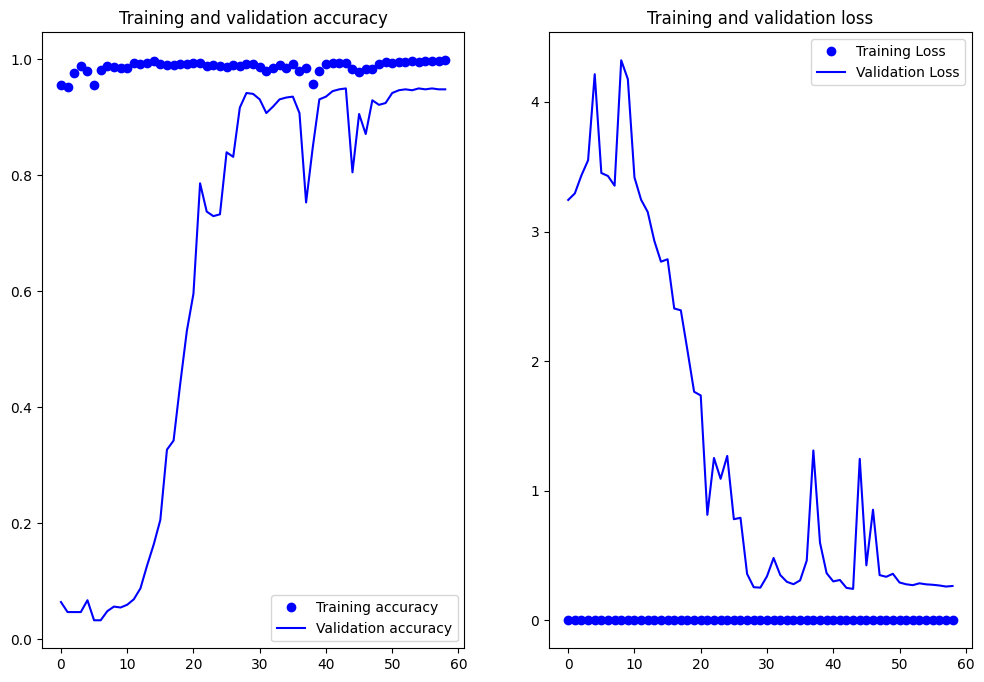

In [61]:

# # Load weights into the model
# custom_resnet.load_weights('model_weights.h5')

# # Compile the model (ensure to compile with the same configuration used during training)
# custom_resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ## Plot the Training and Validation loss
# import matplotlib.pyplot as plt

acc = custom_resnet.history.history['accuracy']
val_acc = custom_resnet.history.history['val_accuracy']
loss = custom_resnet.history.history['loss']
val_loss = custom_resnet.history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Inferencing

In [64]:
import os
import random
import cv2

label_map = {
    'BARN SWALLOW': 0,
    'BARRED PUFFBIRD': 1,
    'BLACK BAZA': 2,
    'BURCHELLS COURSER': 3,
    'COPPERY TAILED COUCAL': 4,
    'EASTERN BLUEBIRD': 5,
    'EMPEROR PENGUIN': 6,
    'Gordon_setter': 7,
    'JACK SNIPE': 8,
    'Leonberg': 9,
    'MOURNING DOVE': 10,
    'SHOEBILL': 11,
    'Shetland_sheepdog': 12,
    'Sussex_spaniel': 13,
    'Tibetan_terrier': 14,
    'flat-coated_retriever': 15,
    'giant_schnauzer': 16,
    'golden_retriever': 17,
    'malinois': 18,
    'toy_terrier': 19
}

base_dir = '/root/42028/AT2/AT2-Part1/image_dataset/'

# Create a dictionary to store the randomly selected images
random_images = {}

# Iterate over each class label folder
for label, index in label_map.items():
    folder_path = os.path.join(base_dir, label)
    # Get the list of files in the folder
    files = os.listdir(folder_path)
    # Randomly select one file
    random_file = random.choice(files)
    # Get the full path to the randomly selected image
    image_path = os.path.join(folder_path, random_file)
    # Read the image using OpenCV
    img = cv2.imread(image_path)
    # Add the image to the dictionary
    random_images[label] = img




In [66]:


# Iterate over each image
for label, img in random_images.items():
    # Preprocess the image
    img = cv2.resize(img, (256, 256))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    # Make predictions
    predictions = custom_resnet.predict(img)

    # Get the class with the highest probability
    class_idx = np.argmax(predictions)

    # Define the label map
    label_map = {
        'BARN SWALLOW': 0,
        'BARRED PUFFBIRD': 1,
        'BLACK BAZA': 2,
        'BURCHELLS COURSER': 3,
        'COPPERY TAILED COUCAL': 4,
        'EASTERN BLUEBIRD': 5,
        'EMPEROR PENGUIN': 6,
        'Gordon_setter': 7,
        'JACK SNIPE': 8,
        'Leonberg': 9,
        'MOURNING DOVE': 10,
        'SHOEBILL': 11,
        'Shetland_sheepdog': 12,
        'Sussex_spaniel': 13,
        'Tibetan_terrier': 14,
        'flat-coated_retriever': 15,
        'giant_schnauzer': 16,
        'golden_retriever': 17,
        'malinois': 18,
        'toy_terrier': 19
    }

    # Get the class label from the label map
    class_label = list(label_map.keys())[list(label_map.values()).index(class_idx)]

    # Print the predicted class
    print(f'The predicted class for {label} is: {class_label}')


1/1 [==============================] - 1s 1s/step
The predicted class for BARN SWALLOW is: BARN SWALLOW
1/1 [==============================] - 0s 32ms/step
The predicted class for BARRED PUFFBIRD is: BARRED PUFFBIRD
1/1 [==============================] - 0s 31ms/step
The predicted class for BLACK BAZA is: BLACK BAZA
1/1 [==============================] - 0s 30ms/step
The predicted class for BURCHELLS COURSER is: BURCHELLS COURSER
1/1 [==============================] - 0s 31ms/step
The predicted class for COPPERY TAILED COUCAL is: COPPERY TAILED COUCAL
1/1 [==============================] - 0s 32ms/step
The predicted class for EASTERN BLUEBIRD is: EASTERN BLUEBIRD
1/1 [==============================] - 0s 30ms/step
The predicted class for EMPEROR PENGUIN is: EMPEROR PENGUIN
1/1 [==============================] - 0s 30ms/step
The predicted class for Gordon_setter is: Gordon_setter
1/1 [==============================] - 0s 31ms/step
The predicted class for JACK SNIPE is: JACK SNIPE
1/1 [=